In [5]:
import numpy as np
import pandas as pd

rng = np.random.default_rng(0)
from glmnet import CoxFamily, CoxLM, CoxNet
from glmnet.glm import GLMControl
import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [6]:
n, p = 1000, 20
status = rng.choice([0, 1], size=n)
start = rng.integers(0, 5, size=n)
event = start + rng.integers(1, 5, size=n) 
event_data = pd.DataFrame({'event':event,
                           'status':status,
                           'start':start})
X = rng.standard_normal((n, p))
event_data

,event,status,start
0,5,1,2
1,1,1,0
2,3,1,0
3,8,0,4
4,6,0,2
...,...,...,...
995,5,1,1
996,3,0,0
997,4,0,0
998,2,0,1


## There are clearly lots of ties

In [7]:
np.unique(event).shape, n

((8,), 1000)

In [8]:
%%R -i event,status,X,start -o C1,C2
library(survival)
Y = Surv(start, event, status)
print(system.time(coxph(Y ~ X, ties='breslow')))
print(system.time(coxph(Y ~ X, ties='efron')))
M1 = coxph(Y ~ X, ties='breslow')
M2 = coxph(Y ~ X, ties='efron')
system.time(print(M1))
C1 = coef(M1)
C2 = coef(M2)

   user  system elapsed 
  0.007   0.000   0.009 
   user  system elapsed 
  0.005   0.000   0.006 
Call:
coxph(formula = Y ~ X, ties = "breslow")

          coef  exp(coef)   se(coef)      z      p
X1   0.0642619  1.0663716  0.0441142  1.457 0.1452
X2  -0.0087449  0.9912932  0.0440329 -0.199 0.8426
X3  -0.0483318  0.9528176  0.0425535 -1.136 0.2560
X4   0.0083994  1.0084347  0.0436629  0.192 0.8475
X5  -0.0339822  0.9665887  0.0437771 -0.776 0.4376
X6  -0.0001727  0.9998273  0.0450505 -0.004 0.9969
X7  -0.0022471  0.9977555  0.0439749 -0.051 0.9592
X8  -0.0173664  0.9827835  0.0445080 -0.390 0.6964
X9   0.0116408  1.0117089  0.0434779  0.268 0.7889
X10 -0.0431496  0.9577681  0.0422425 -1.021 0.3070
X11 -0.0665842  0.9355841  0.0427945 -1.556 0.1197
X12  0.0044881  1.0044982  0.0443466  0.101 0.9194
X13  0.0553870  1.0569495  0.0460602  1.202 0.2292
X14  0.0019385  1.0019404  0.0442255  0.044 0.9650
X15  0.0157209  1.0158451  0.0433237  0.363 0.7167
X16  0.0535363  1.0549953  0.0450234

In [9]:
import time
toc = time.time()
cox_fam1 = CoxFamily(start_col='start', tie_breaking='breslow')
G1 = CoxLM(family=cox_fam1)
print(np.linalg.norm(G1.fit(X, event_data).coef_ - C1) / np.linalg.norm(C1))
tic = time.time()
print(f'time: {tic-toc}')


3.9062704429025495e-06
time: 0.044992923736572266


In [10]:
%%R
dim(M1$var)

[1] 20 20


In [11]:
%%timeit
G1 = CoxLM(family=cox_fam1)
G1.fit(X, event_data)

7.09 ms ± 500 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
cox_fam2 = CoxFamily(start_col='start', tie_breaking='efron')
G2 = CoxLM(family=cox_fam2)
np.linalg.norm(G2.fit(X, event_data).coef_ - C2) / np.linalg.norm(C2)

4.159217327840236e-06

In [13]:
%%timeit
G2 = CoxLM(family=cox_fam2)
G2.fit(X, event_data)

7.38 ms ± 267 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
np.linalg.norm(C1-C2) / np.linalg.norm(C1)

0.13507057439276787

In [15]:
V = rng.standard_normal(n)

In [16]:
%%timeit
for _ in range(200):
    V = rng.standard_normal(n)
    W = np.ones(n)
    G1._family._coxdev(V, W)
np.linalg.inv(X.T @ X)

59.1 ms ± 1.98 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
G3 = CoxNet(family=cox_fam1)
G3.fit(X, event_data)

CoxNet(lambda_values=array([1.00000000e+00, 9.11162756e-01, 8.30217568e-01, 7.56463328e-01,
       6.89261210e-01, 6.28029144e-01, 5.72236766e-01, 5.21400829e-01,
       4.75081016e-01, 4.32876128e-01, 3.94420606e-01, 3.59381366e-01,
       3.27454916e-01, 2.98364724e-01, 2.71858824e-01, 2.47707636e-01,
       2.25701972e-01, 2.05651231e-01, 1.87381742e-01, 1.70735265e-01,
       1.55567614e-01, 1.41747416e-01, 1.29154967e-01, 1.17681195e-01,
       1.07226722e-01, 9.77009957e-02, 8.90215085e-02, 8.11130831e-02,
       7.39072203e-02, 6.73415066e-02, 6.13590727e-02, 5.59081018e-02,
       5.09413801e-02, 4.64158883e-02, 4.22924287e-02, 3.85352859e-02,
       3.51119173e-02, 3.19926714e-02, 2.91505306e-02, 2.65608778e-02,
       2.42012826e-02, 2.20513074e-02, 2.00923300e-02, 1.83073828e-02,
       1.66810054e-02, 1.51991108e-02, 1.38488637e-02, 1.26185688e-02,
       1.14975700e-02, 1.04761575e-02, 9.54548457e-03, 8.69749003e-03,
       7.92482898e-03, 7.22080902e-03, 6.57933225e-03, 5.99484250e-03,
       5.46227722e-03, 4.97702356e-03, 4.53487851e-03, 4.13201240e-03,
       3.76493581e-03, 3.43046929e-03, 3.12571585e-03, 2.84803587e-03,
       2.59502421e-03, 2.36448941e-03, 2.15443469e-03, 1.96304065e-03,
       1.78864953e-03, 1.62975083e-03, 1.48496826e-03, 1.35304777e-03,
       1.23284674e-03, 1.12332403e-03, 1.02353102e-03, 9.32603347e-04,
       8.49753436e-04, 7.74263683e-04, 7.05480231e-04, 6.42807312e-04,
       5.85702082e-04, 5.33669923e-04, 4.86260158e-04, 4.43062146e-04,
       4.03701726e-04, 3.67837977e-04, 3.35160265e-04, 3.05385551e-04,
       2.78255940e-04, 2.53536449e-04, 2.31012970e-04, 2.10490414e-04,
       1.91791026e-04, 1.74752840e-04, 1.59228279e-04, 1.45082878e-04,
       1.32194115e-04, 1.20450354e-04, 1.09749877e-04, 1.00000000e-04]), lambda_fractional=True, alpha=1.0, lower_limits=-inf, upper_limits=inf, penalty_factor=None, fit_intercept=False, standardize=True, family=CoxFamily(tie_breaking='breslow', event_col='event', status_col='status', start_col='start'), control=GLMNetControl(thresh=1e-07, maxit=100000, big=9.9e+35, logging=False, mxitnr=25, epsnr=1e-06, fdev=1e-05), regularized_estimator=<class 'glmnet.cox.RegCoxLM'>)

<Axes: xlabel='$\\|\\beta(\\lambda)\\|_1$', ylabel='Coefficients ($\\beta$)'>

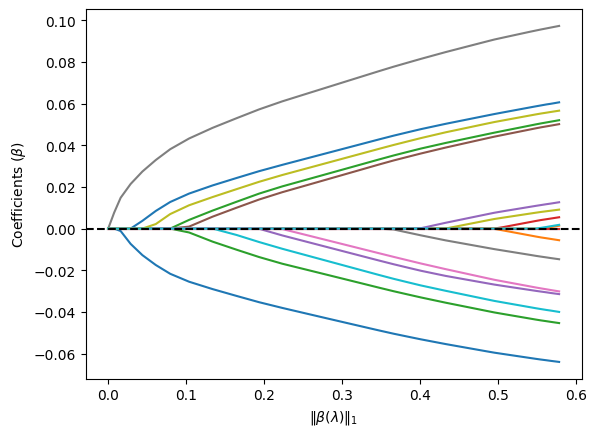

In [18]:
G3.plot_coefficients(xvar='norm')

<Axes: xlabel='$\\|\\beta(\\lambda)\\|_1$', ylabel='Cox Deviance'>

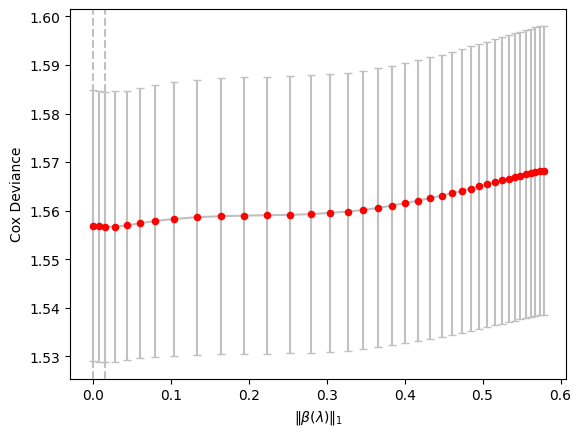

In [19]:
G3.cross_validation_path(X, event_data)
G3.plot_cross_validation(xvar='norm')